In [1]:
from typing import Any, Dict, List, Optional
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
from database.models.Block import Block
from database.models.Tx import Tx
from database.models.Receipt import Receipt
from database.models.Ticker_ETHUSDT_15m import Ticker_ETHUSDT_15m
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as fplt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
import ta
import eli5

import warnings
from datetime import datetime

import cloudpickle

pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)

Create session to DB

In [2]:
engine = create_engine("sqlite:///db.sqlite")
session_factory = sessionmaker(bind=engine)
Session = scoped_session(session_factory)
session = Session()


Get BLOCKS, TRANSACTIONS, RECEIPTS, TICKER data from DB

In [3]:
class TickerBlocksDfConstructor():
    def __init__(self, session: Session) -> None:
        self._session = session

        self._blocks: pd.DataFrame
        self._txs: pd.DataFrame
        self._receipts: pd.DataFrame
        self._ticker: pd.DataFrame

        self._first_block_num: int = 0
        self._last_block_num: int = 0
        self._first_block_timestamp: int = 0
        self._last_block_timestamp: int = 0

        self._blocks_size_means: List[int] = []
        self._blocks_size_sums: List[int] = []
        self._blocks_gas_used_totals: List[int] = []
        self._blocks_base_fees_per_gas: List[int] = []
        self._txs_mean_per_block: List[int] = []
        self._blocks_gas_used_means: List[int] = []
        self._txs_max_fee_per_gas_mean: List[int] = []
        self._txs_count_per_candle: List[int] = []
        self._txs_gas_price_mean: List[int] = []
        self._txs_max_priority_per_gas_mean: List[int] = []
        self._txs_value_mean: List[int] = []
        self._txs_value_sum: List[int] = []
        self._rcpts_effec_gas_price_mean: List[int] = []
        self._rcpts_cumul_gas_used_mean: List[int] = []
        self._rcpts_contract_tx_mean_per_block: List[int] = []
        self._rcpts_contract_tx_count: List[int] = []

    def get_blocks(self)-> pd.DataFrame:
        return self._blocks
    
    def get_txs(self)-> pd.DataFrame:
        return self._txs

    def get_receipts(self)-> pd.DataFrame:
        return self._receipts

    def get_ticker(self)-> pd.DataFrame:
        return self._ticker
    
    def fetch_from_database(self) -> None:
        blocks = [row.__dict__ for row in self._session.query(Block).all()]
        self._blocks  = pd.DataFrame(blocks)
        del self._blocks["_sa_instance_state"]
        self._blocks.set_index("timestamp", inplace=True)
        self._first_block_num = int(self._blocks["blockNumber"].min())
        self._last_block_num = int(self._blocks["blockNumber"].max())
        self._first_block_timestamp = int(self._blocks.index.min())
        self._last_block_timestamp = int(self._blocks.index.max())

        txs = [row.__dict__ for row in self._session.query(Tx).all()]
        self._txs = pd.DataFrame(txs)
        del self._txs["_sa_instance_state"]

        receipts = [row.__dict__ for row in self._session.query(Receipt).all()]
        self._receipts = pd.DataFrame(receipts) 
        del self._receipts["_sa_instance_state"]

        ticker = [row.__dict__ for row in self._session.query(Ticker_ETHUSDT_15m).filter((Ticker_ETHUSDT_15m.open_time >= self._first_block_timestamp*1000) & (Ticker_ETHUSDT_15m.close_time <= self._last_block_timestamp*1000))]
        self._ticker = pd.DataFrame(ticker) 
        del self._ticker["_sa_instance_state"]
        

    def agregate_data(self) -> pd.DataFrame:
        data = self._ticker.copy()
        for index, tick in self._ticker.iterrows():
            block_timestamp = self._blocks.index*1000
            blocks = self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["blockNumber"].tolist()

            self._blocks_size_sums.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["size"].sum())
            self._blocks_size_means.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["size"].mean())
            self._blocks_base_fees_per_gas.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["baseFeePerGas"].mean())
            self._blocks_gas_used_totals.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["gasUsed"].sum())
            self._blocks_gas_used_means.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["gasUsed"].mean())
            self._txs_mean_per_block.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "blockNumber"].count()/len(blocks))
            self._txs_count_per_candle.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "blockNumber"].count())
            self._txs_max_fee_per_gas_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "maxFeePerGas"].mean())
            self._txs_max_priority_per_gas_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "maxPriorityFeePerGas"].mean())
            self._txs_gas_price_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "gasPrice"].mean())
            self._txs_value_sum.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "value"].sum())
            self._txs_value_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "value"].mean())
            self._rcpts_cumul_gas_used_mean.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "cumulativeGasUsed"].mean())
            self._rcpts_effec_gas_price_mean.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "effectiveGasPrice"].mean())
            self._rcpts_contract_tx_count.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "contractAddress"].count())
            self._rcpts_contract_tx_mean_per_block.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "contractAddress"].count()/len(blocks))

        data["blocks_size_sum"] = self._blocks_size_sums
        data["blocks_size_mean"] = self._blocks_size_means
        data["blocks_base_fee_per_gas"] = self._blocks_base_fees_per_gas
        data["txs_mean_per_block"] = self._txs_mean_per_block
        data["txs_count_per_candle"] = self._txs_count_per_candle
        data["txs_max_fee_per_gas_mean"] = self._txs_max_fee_per_gas_mean
        data["txs_max_priority_per_gas_mean"] = self._txs_max_priority_per_gas_mean
        data["txs_gas_price_mean"] = self._txs_gas_price_mean
        data["txs_value_sum"] = self._txs_value_sum
        data["txs_value_mean"] = self._txs_value_mean
        data["rcpts_cumul_gas_used_mean"] = self._rcpts_cumul_gas_used_mean
        data["rcpts_effec_gas_price_mean"] = self._rcpts_effec_gas_price_mean
        data["rcpts_contract_tx_count"] = self._rcpts_contract_tx_count
        data["rcpts_contract_tx_mean_per_block"] = self._rcpts_contract_tx_mean_per_block

        data['close_time'] = data['close_time'].values.astype(dtype='datetime64[ms]')
        data['open_time'] = data['open_time'].values.astype(dtype='datetime64[ms]')

        return data
    
    def fetch_and_merge_data(self) -> pd.DataFrame:
        self.fetch_from_database()
        return self.agregate_data() 
    

Creating base dataframes

In [4]:
data = TickerBlocksDfConstructor(session)
df = data.fetch_and_merge_data()
ticker = data.get_ticker()
blocks = data.get_blocks()
txs = data.get_txs()
receipts = data.get_receipts()

Data info

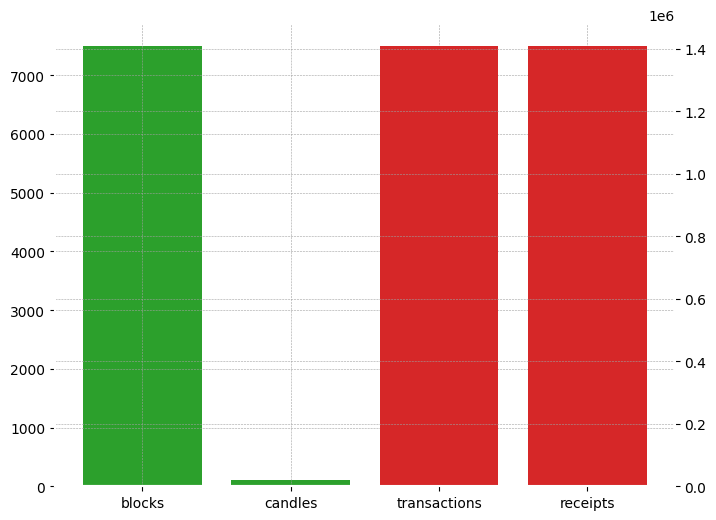

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
labels = ["blocks", "candles", "transactions", "receipts"]
values = [len(blocks), len(ticker), len(txs), len(receipts)]
ax.bar(["blocks", "candles", "transactions", "receipts"], [len(blocks), len(ticker), 0, 0], color="tab:green")
ax1 = ax.twinx()
ax1.bar(["blocks", "candles", "transactions", "receipts"], [0, 0, len(txs), len(receipts)], color="tab:red")
plt.show()


Some data from Binance

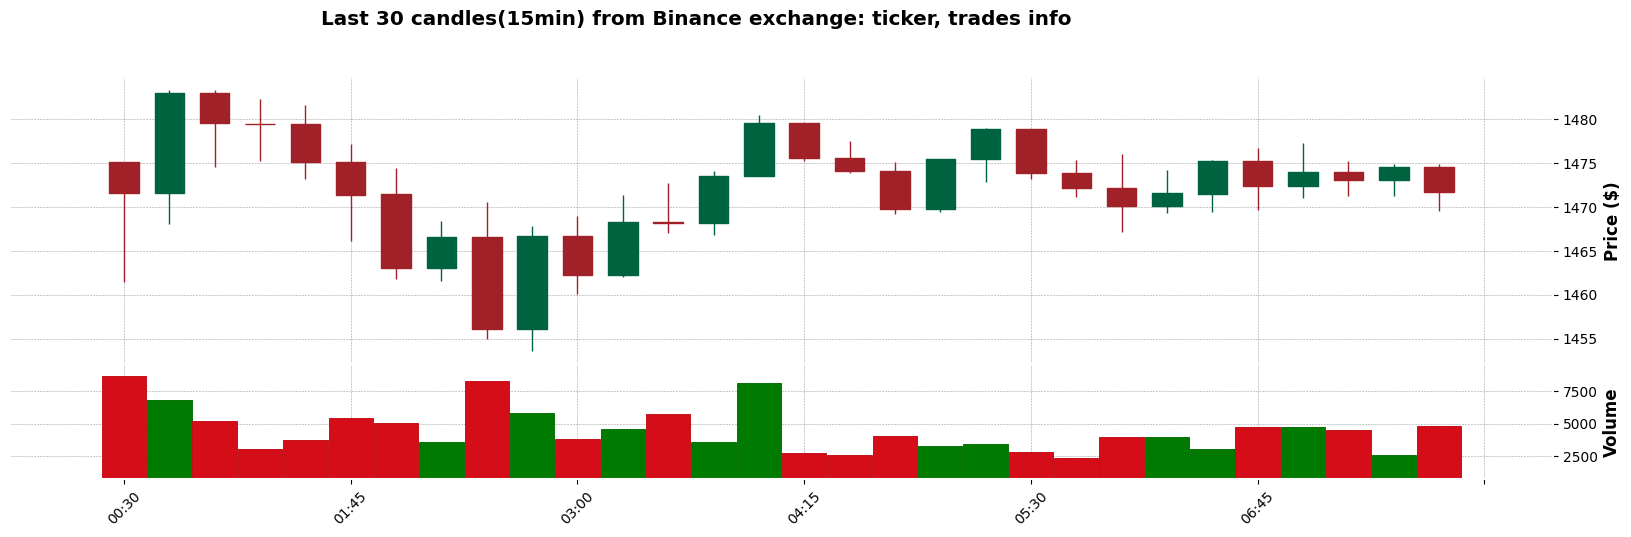

In [5]:

ticker = ticker.loc[:,("open_time", "open", "close", "high", "low", "volume")]
ticker['date'] = ticker['open_time'].values.astype(dtype='datetime64[ms]')
ticker.index = pd.DatetimeIndex(ticker['date'])
img = fplt.plot(
            ticker.tail(30),
            type='candle',
            style='charles',
            title='Last 30 candles(15min) from Binance exchange: ticker, trades info',
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            figratio=(82,22)
            );


Some features from blockchain


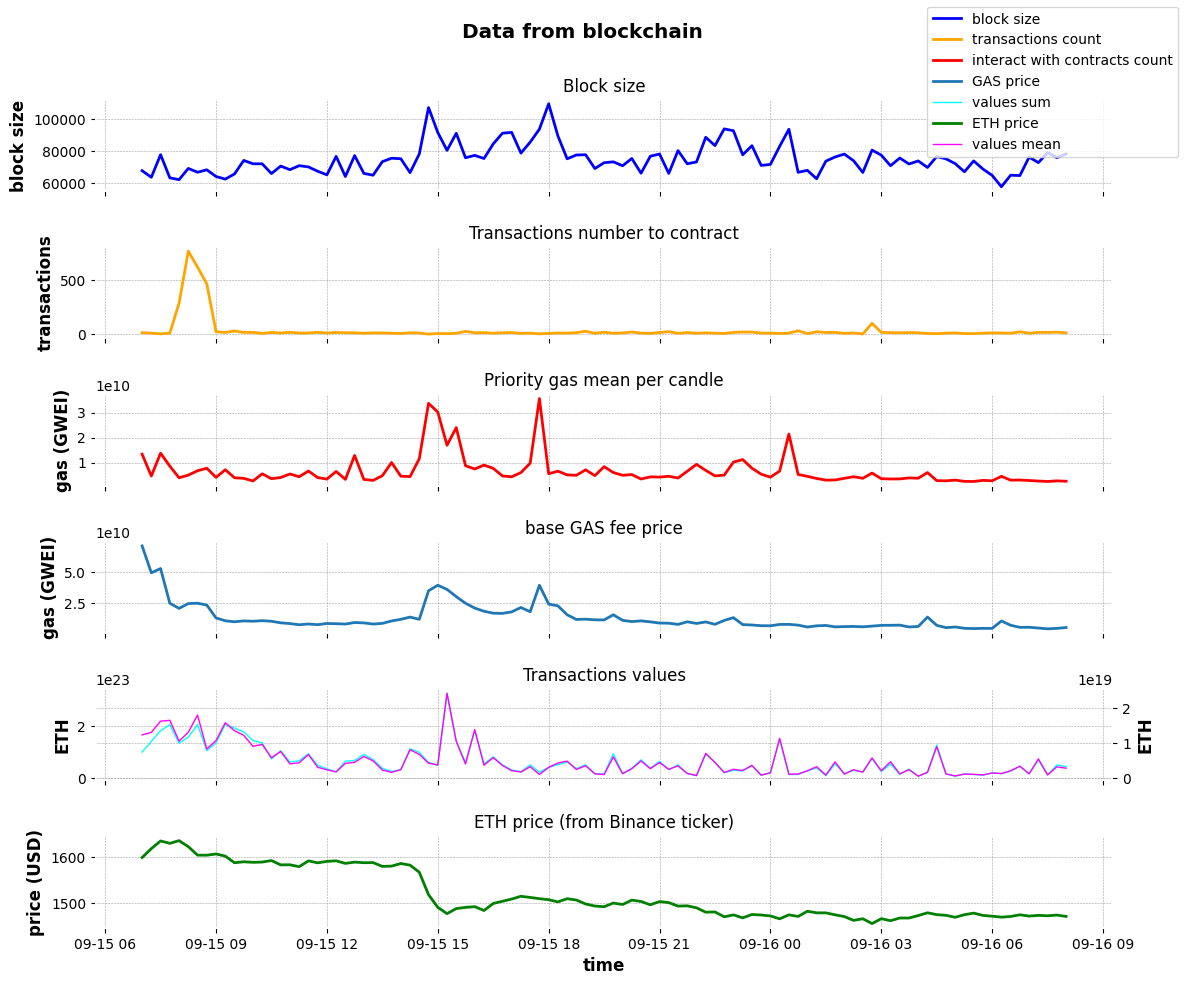

In [6]:
fig, axs = plt.subplots(6, sharex=True, figsize=(12,10))
fig.suptitle('Data from blockchain')

# axs[0].plot(df["close_time"], df["blocks_size_mean"], c="red")
axs[0].plot(df["close_time"], df["blocks_size_mean"], color="blue", label="block size")
axs[0].set_title("Block size")
axs[0].set_ylabel("block size")

axs[1].plot(df["close_time"], df["rcpts_contract_tx_count"], color="orange", label="transactions count")
axs[1].set_ylabel("transactions")
axs[1].set_title("Transactions number to contract")

axs[2].plot(df["close_time"], df["txs_max_priority_per_gas_mean"], color="red", label="interact with contracts count")
axs[2].set_title("Priority gas mean per candle")
axs[2].set_ylabel("gas (GWEI)")

axs[3].plot(df["close_time"], df["blocks_base_fee_per_gas"], color="tab:blue", label="GAS price")
axs[3].set_title("base GAS fee price")
axs[3].set_ylabel("gas (GWEI)")

axs[4].plot(df["close_time"], df["txs_value_sum"], color="cyan", label="values sum", lw=1)
axs41= axs[4].twinx()
axs41.plot(df["close_time"], df["txs_value_mean"], color="magenta", label="values mean", lw=1)
axs41.set_ylabel("ETH")
axs[4].set_title("Transactions values")
axs[4].set_ylabel("ETH")

axs[5].plot(df["close_time"], df["close"], color="green", label="ETH price", lw=2)
axs[5].set_title("ETH price (from Binance ticker)")
axs[5].set_ylabel("price (USD)")
axs[5].set_xlabel("time")
fig.tight_layout(pad=2.0)
fig.legend();

In [7]:
df.head(2)

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block
0,1599.85,2022-09-15 06:45:00,1634.90,2022-09-15 06:59:59.999,84035,57187354.58,1580.10,1596.90,70719.24,113626302.03,35577.09,5013042,67743.81,71178182467.20,110.65,8188,133267508917.13,13359332194.47,83174912105.29,101082683801613153337344.00,12345222740793008128.00,9252197.62,83174912105.29,14,0.19
1,1619.31,2022-09-15 07:00:00,1619.90,2022-09-15 07:14:59.999,45892,27505391.65,1595.50,1599.86,36116.40,58098122.57,17091.59,4705504,63587.89,49444776841.95,146.77,10861,94843006745.55,4588004919.18,54438118025.69,142006088173667349430272.00,13074863104103430144.00,11041895.97,54438118025.69,10,0.14


In [8]:
class CalculateTaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X: pd.DataFrame, y: Optional[Any] = None):
        return self

    def transform(self, X: pd.DataFrame, y: Optional[Any] = None) -> int:
        data = X.copy()
        data = ta.add_volume_ta(data, "high", "low", "close", "volume", fillna=True)
        data = ta.add_others_ta(data, "close", fillna=True)
        data = ta.add_volatility_ta(data, "high", "low", "close", fillna=True)
        data.drop(["volatility_bbhi", "volatility_kchi"], axis=1, inplace=True)
        return data

In [10]:
class CreateLabelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X: pd.DataFrame, y: Optional[Any] = None):
        return self

    def transform(self, X: pd.DataFrame, y: Optional[Any] = None) -> int:
        data = X.copy()
        data.sort_values(by="close_time", ascending=False, inplace=True)
        data["next_candle_close"] = data.close.shift(periods=1)
        data.drop(data.head(1).index,inplace=True)
        return data

In [11]:
tr = CalculateTaTransformer()
data = tr.fit_transform(df)
tr = CreateLabelTransformer()
data = tr.fit_transform(data)
data.head(5)

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,others_dr,others_dlr,others_cr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,next_candle_close
99,1474.58,2022-09-16 07:30:00,1474.93,2022-09-16 07:44:59.999,5594,1737009.10,1471.29,1473.09,2547.62,3751800.83,1179.56,5618991,75932.31,4556215407.58,214.92,15904,42001595130.33,2658769980.79,8560794246.89,51488562611232419348480.00,3237459922738457088.00,10273021.19,8560794246.89,19,0.26,-32998.40,-31619.56,0.09,888.08,-22146.16,-39109.30,-0.13,1473.53,42.98,1000.99,0.10,0.10,-7.83,1472.47,1480.43,1464.51,1.08,0.63,0.00,1473.51,1479.17,1467.84,0.77,0.59,0.00,1453.56,1480.44,1467.00,1.83,0.78,6.55,0.43,1471.70
98,1473.09,2022-09-16 07:15:00,1475.26,2022-09-16 07:29:59.999,8082,2901526.12,1471.27,1473.98,4482.36,6601788.22,1970.03,5773398,79087.64,4174322177.97,188.67,13773,37566282586.75,2414189310.10,7573945447.03,12776295889665051852800.00,927633477794601856.00,9089289.66,7573945447.03,16,0.22,-35056.09,-34167.18,-0.02,403.44,-78778.88,2094.68,2.52,1474.17,48.90,999.97,-0.06,-0.06,-7.92,1471.54,1482.16,1460.93,1.44,0.57,0.00,1473.49,1479.41,1467.58,0.80,0.47,0.00,1453.56,1480.44,1467.00,1.83,0.73,6.87,0.43,1474.58
97,1473.98,2022-09-16 07:00:00,1477.27,2022-09-16 07:14:59.999,8548,3774786.84,1471.03,1472.37,4747.53,7000312.54,2560.13,5023369,72802.45,4828071463.67,184.26,12714,38095269810.47,2579586343.54,8774321807.50,70033997132427520114688.00,5508415693914387456.00,9302527.13,8774321807.50,17,0.25,-34662.90,-29684.82,0.00,1135.56,122236.13,15673.30,-4.03,1474.07,56.43,1000.58,0.11,0.11,-7.87,1471.22,1482.02,1460.42,1.47,0.63,0.00,1473.31,1479.41,1467.20,0.83,0.56,0.00,1453.56,1480.44,1467.00,1.83,0.76,7.20,0.44,1473.09
96,1472.36,2022-09-16 06:45:00,1476.74,2022-09-16 06:59:59.999,8560,3743915.17,1469.70,1475.23,4741.17,6980765.25,2542.81,5493687,76301.21,5440622748.81,198.25,14274,39446323621.57,2796704195.60,9588631271.46,17528158917016185470976.00,1227978066205421312.00,9482564.41,9588631271.46,9,0.12,-34404.23,-34432.35,-0.04,42.98,121016.47,29602.98,-1.68,1473.57,57.19,1000.58,-0.20,-0.20,-7.97,1470.67,1481.95,1459.39,1.53,0.57,0.00,1473.41,1479.27,1467.56,0.79,0.41,0.00,1453.56,1480.44,1467.00,1.83,0.70,7.30,0.51,1473.98
95,1475.24,2022-09-16 06:30:00,1475.41,2022-09-16 06:44:59.999,6717,2305863.04,1469.40,1471.53,3014.55,4435384.19,1567.12,4850892,64678.56,5367590066.11,182.36,13677,39769637177.81,2979935348.00,9627859527.48,46636914201423809347584.00,3409878935543160832.00,9760933.15,9627859527.48,22,0.29,-33245.87,-29691.18,-0.03,2325.91,137562.99,52263.41,11.50,1473.09,65.79,1000.58,0.25,0.25,-7.79,1470.62,1481.89,1459.36,1.53,0.70,0.00,1473.80,1479.39,1468.21,0.76,0.63,0.00,1453.56,1480.44,1467.00,1.83,0.81,7.33,0.56,1472.36


In [12]:
data.columns

Index(['close', 'open_time', 'high', 'close_time', 'number_of_trades',
       'taker_buy_quote_asset_volume', 'low', 'open', 'volume',
       'quote_asset_volume', 'taker_buy_base_asset_volume', 'blocks_size_sum',
       'blocks_size_mean', 'blocks_base_fee_per_gas', 'txs_mean_per_block',
       'txs_count_per_candle', 'txs_max_fee_per_gas_mean',
       'txs_max_priority_per_gas_mean', 'txs_gas_price_mean', 'txs_value_sum',
       'txs_value_mean', 'rcpts_cumul_gas_used_mean',
       'rcpts_effec_gas_price_mean', 'rcpts_contract_tx_count',
       'rcpts_contract_tx_mean_per_block', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'others_dr', 'others_dlr',
       'others_cr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_k

In [13]:
cont_features = ["low", "open", "volume", "quote_asset_volume",
       "taker_buy_base_asset_volume", "close", "high", "number_of_trades", "taker_buy_quote_asset_volume",
       "blocks_size_sum", "blocks_size_mean", "blocks_base_fee_per_gas",
       "txs_mean_per_block", "txs_count_per_candle",
       "txs_max_fee_per_gas_mean", "txs_max_priority_per_gas_mean",
       "txs_gas_price_mean", "txs_value_sum", "txs_value_mean",
       "rcpts_cumul_gas_used_mean", "rcpts_effec_gas_price_mean",
       "rcpts_contract_tx_count", "rcpts_contract_tx_mean_per_block",
       "volume_adi", "volume_obv", "volume_cmf", "volume_fi", "volume_em",
       "volume_sma_em", "volume_vpt", "volume_vwap", "volume_mfi",
       "volume_nvi", "others_dr", "others_dlr", "others_cr", "volatility_bbm",
       "volatility_bbh", "volatility_bbl", "volatility_bbw", "volatility_bbp",
       "volatility_bbli", "volatility_kcc", "volatility_kch", "volatility_kcl",
       "volatility_kcw", "volatility_kcp", "volatility_kcli", "volatility_dcl",
       "volatility_dch", "volatility_dcm", "volatility_dcw", "volatility_dcp",
       "volatility_atr", "volatility_ui"]

label = "next_candle_close"

/var/folders/jt/jttvrgbx7pxgyn407jvmp9000000gn/T/ipykernel_54692/2542884392.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


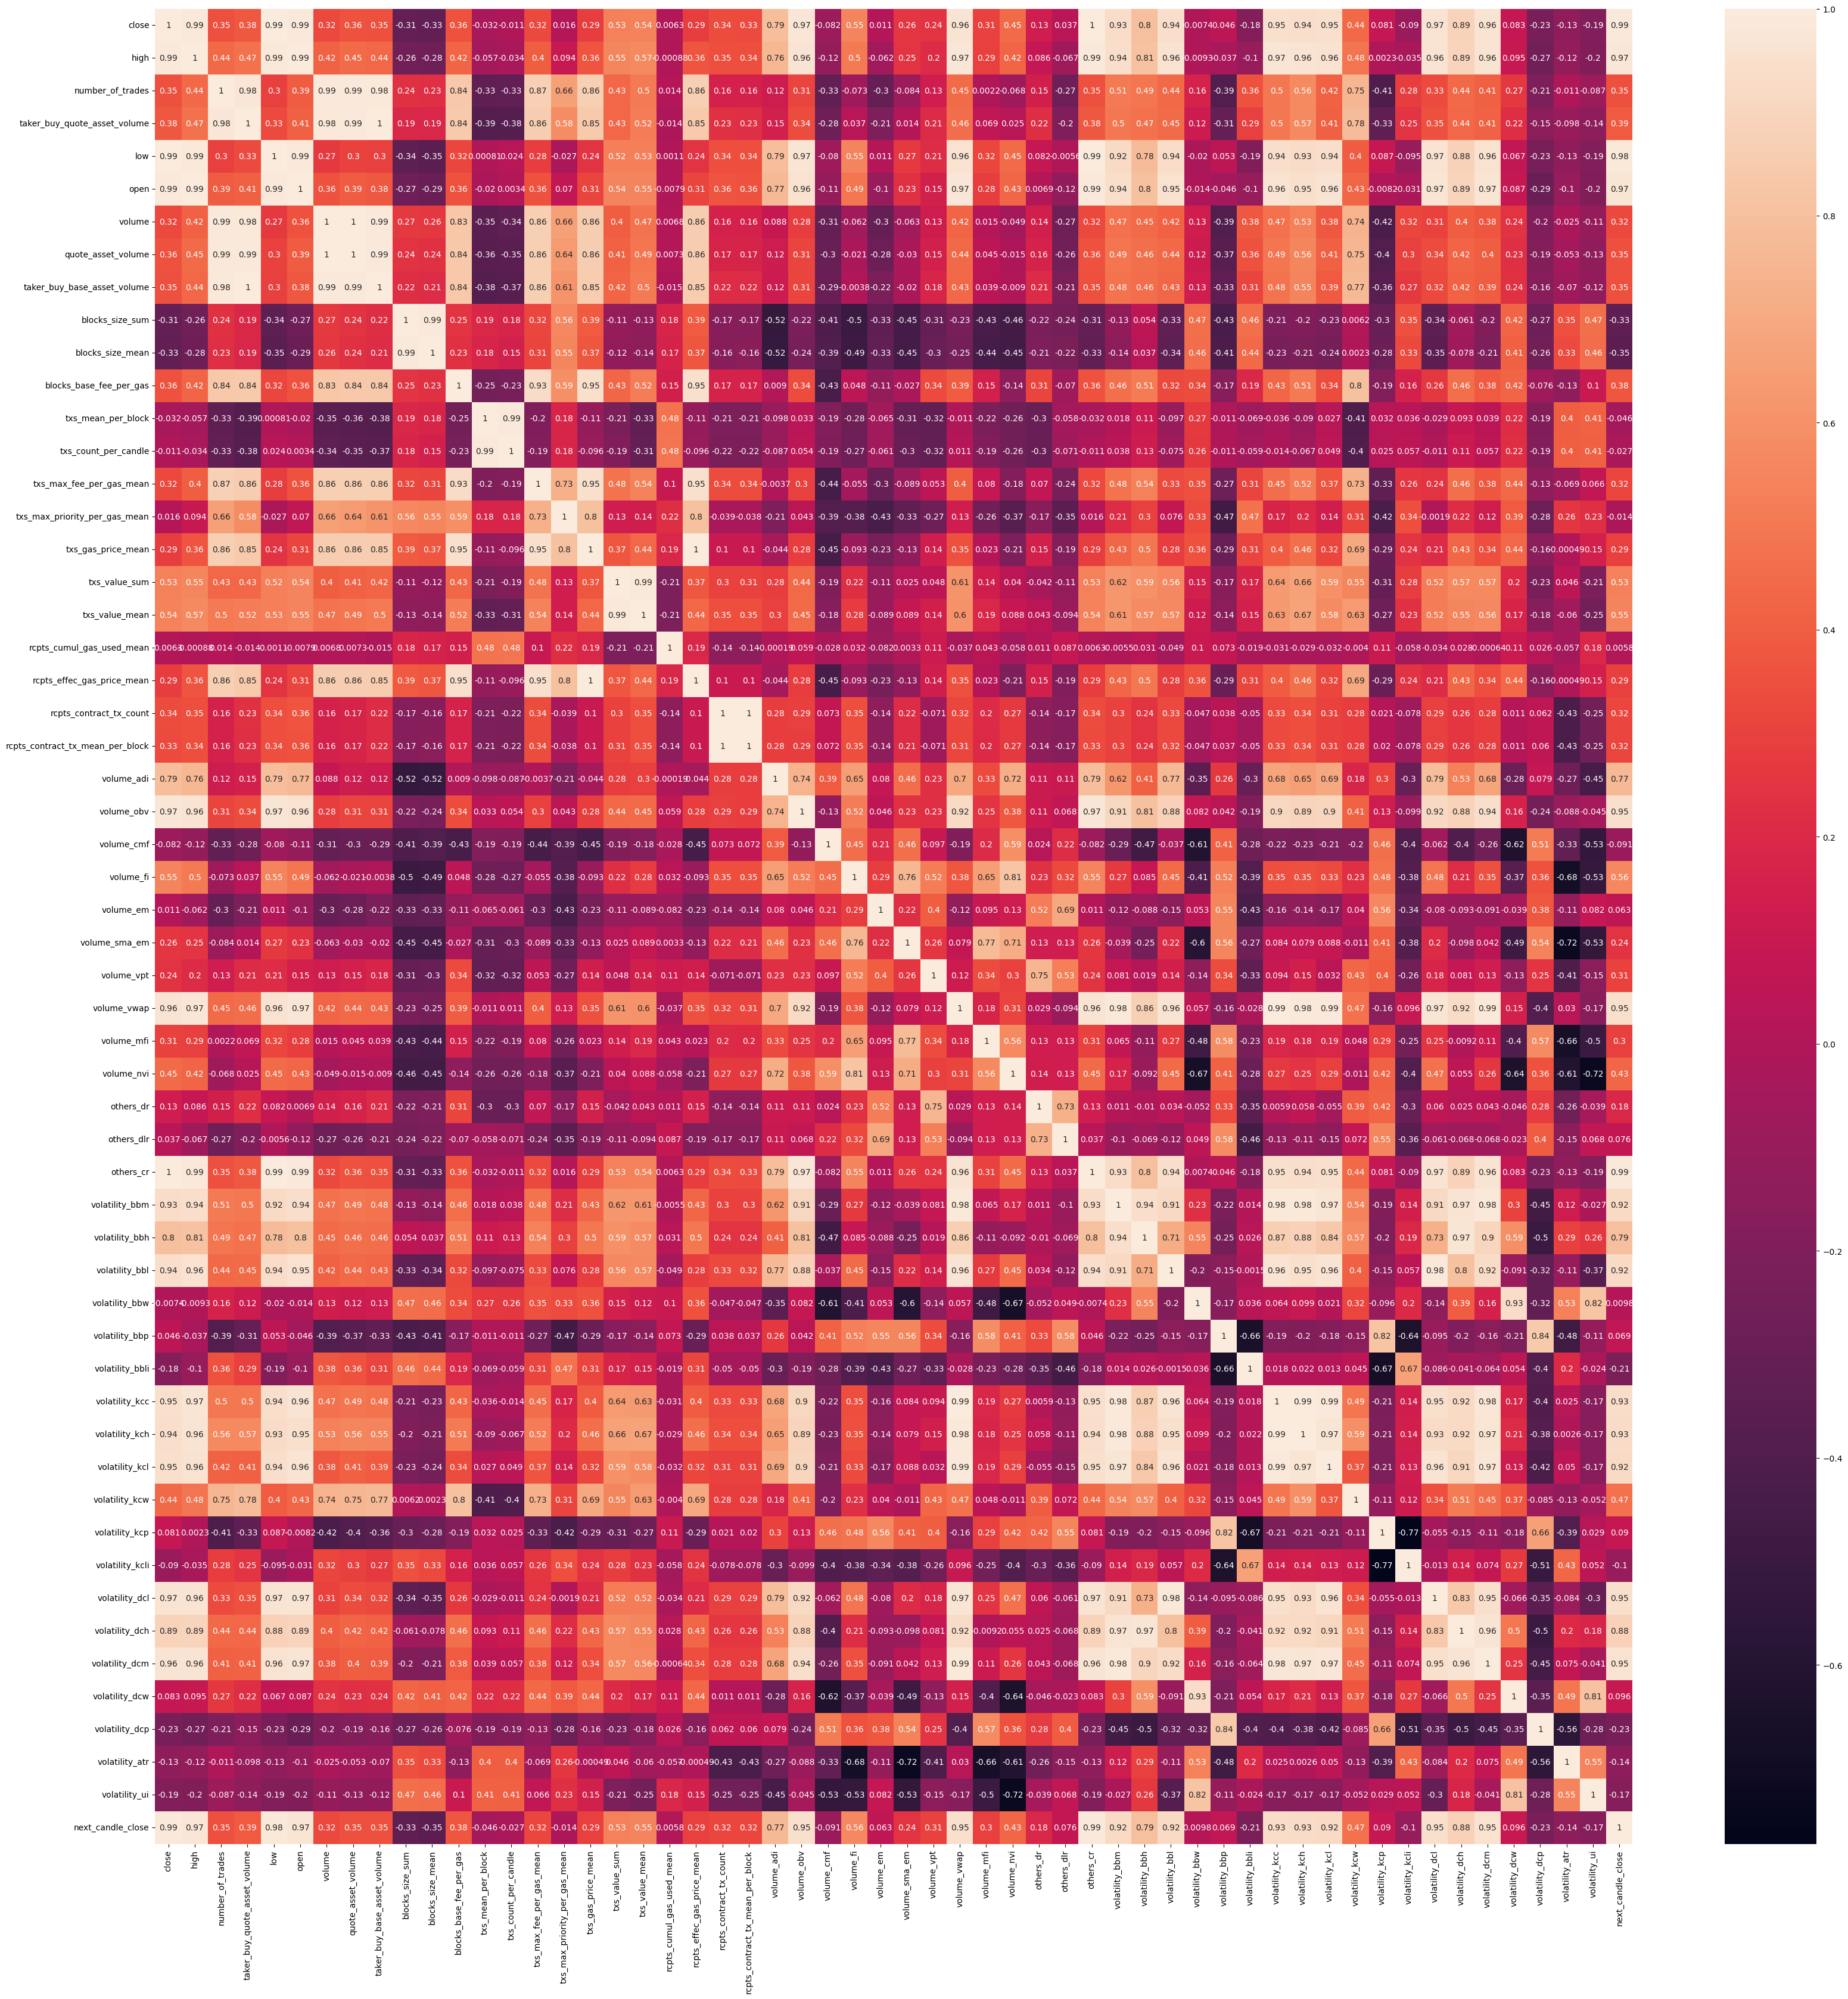

In [14]:
plt.figure(figsize=(40, 40))
corr = data.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [15]:
cont_pipeline = Pipeline([
    ("scaler", StandardScaler()),
])

In [16]:
pipeline = Pipeline([
    ("ColumnTransformer", ColumnTransformer([
        ("cont_transformer", cont_pipeline, cont_features),
    ])),
    ("model", LinearRegression())
])

In [17]:
train_df, test_df = train_test_split(data)
print("Train size: ", train_df.size)
print("Test size: ", test_df.size)

Train size:  4350
Test size:  1450


In [18]:
pipeline.fit(train_df, train_df["next_candle_close"].values)

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('cont_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['low', 'open', 'volume',
                                                   'quote_asset_volume',
                                                   'taker_buy_base_asset_volume',
                                                   'close', 'high',
                                                   'number_of_trades',
                                                   'taker_buy_quote_asset_volume',
                                                   'blocks_size_sum',
                                                   'blocks_size_mean',
                                                   'blocks_base_fee_per_gas',
                                                   'txs_mean_per...
                                                   'txs_max_fee_per_gas_mean',
                                                   'txs_max_priority_per_gas_mean',
                                                   'txs_gas_price_mean',
                                                   'txs_value_sum',
                                                   'txs_value_mean',
                                                   'rcpts_cumul_gas_used_mean',
                                                   'rcpts_effec_gas_price_mean',
                                                   'rcpts_contract_tx_count',
                                                   'rcpts_contract_tx_mean_per_block',
                                                   'volume_adi', 'volume_obv',
                                                   'volume_cmf', 'volume_fi',
                                                   'volume_em', 'volume_sma_em',
                                                   'volume_vpt', ...])])),
                ('model', LinearRegression())])

In [21]:
print("LinearReg")
predictions = pipeline.predict(test_df)
print("MAE: ", mean_absolute_error(test_df["next_candle_close"], predictions))
print("MSE: ", mean_squared_error(test_df["next_candle_close"], predictions))

LinearReg
MAE:  12.853866754018636
MSE:  293.6362043279764


In [22]:
test_df.head(1)

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,others_dr,others_dlr,others_cr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,next_candle_close
23,1589.90,2022-09-15 12:30:00,1600.00,2022-09-15 12:44:59.999,23267,11248347.99,1582.98,1587.12,14321.20,22788959.13,7068.75,5639023,77246.89,9294755967.70,207.25,15129,49830092233.63,12848446985.59,21306747739.53,68507103943864866570240.00,4528197762169665536.00,10184019.07,21306747739.53,13,0.18,8099.75,102724.92,-0.01,23119.14,301271.50,-83841.38,4.91,1588.74,44.06,996.26,0.18,0.18,-0.62,1596.16,1623.31,1569.00,3.40,0.38,0.00,1587.86,1598.56,1577.17,1.35,0.60,0.00,1574.46,1637.13,1605.80,3.93,0.25,13.81,2.40,1588.64


In [23]:
pipeline.predict(test_df.head(1))

array([1625.36011845])

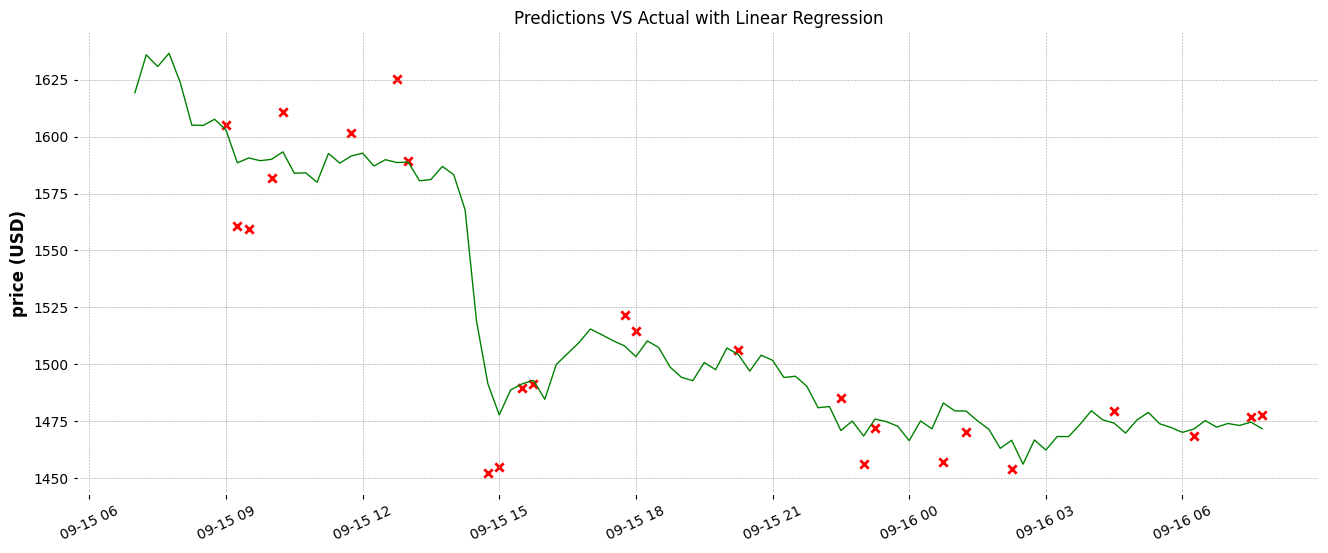

In [25]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.plot(data["close_time"], data["next_candle_close"], color="green", label="values sum", lw=1)
ax.scatter(test_df["close_time"], pipeline.predict(test_df), color="red", label="values mean", marker="x")
ax.set_title("Predictions VS Actual with Linear Regression")
ax.set_ylabel("price (USD)")
plt.xticks(rotation=25)
plt.show();

In [26]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [27]:
feature_names = get_feature_names(pipeline.named_steps["ColumnTransformer"])

/var/folders/jt/jttvrgbx7pxgyn407jvmp9000000gn/T/ipykernel_54692/2197783060.py:30: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [28]:
eli5.explain_weights(pipeline.named_steps["model"], top=50, feature_names=feature_names)

Weight?,Feature
+1518.145,<BIAS>
+353.989,cont_transformer__volatility_kcl
+186.613,cont_transformer__volatility_dcl
+140.452,cont_transformer__volume
+132.083,cont_transformer__taker_buy_quote_asset_volume
+113.285,cont_transformer__volatility_kcw
+97.025,cont_transformer__volatility_bbh
+93.702,cont_transformer__volatility_dcw
+64.336,cont_transformer__low
+63.009,cont_transformer__open


In [29]:
pipeline = Pipeline([
    ("ColumnTransformer", ColumnTransformer([
        ("cont_transformer", cont_pipeline, cont_features),
    ])),
    ("model", XGBRegressor())
])

In [30]:
# Searching for the best hyperparams

def extract_best_model_params(params: Dict[str, Any]) -> Dict[str, Any]:
    filtered_dict = {}
    for key, value in params.items():
        if "model__" in key:
            filtered_dict[key.split("model__")[-1]] = value
    return filtered_dict

In [31]:

params = {
    "model__max_depth": [8, 100],
    "model__learning_rate": [0.001, 0.7],
    "model__colsample_bylevel": [0.3, 0.4],
}

forrest = pipeline

search = RandomizedSearchCV(forrest, params, n_iter=100, cv=7, random_state=42, n_jobs=-1)
search.fit(train_df, train_df["next_candle_close"].values)
print(extract_best_model_params(search.best_estimator_.get_params()))



pipeline = Pipeline(
    [
        (
            "ColumnTransformer",
            ColumnTransformer(
                [
                    ("cont_transformer", cont_pipeline, cont_features),
                ]
            ),
        ),
        ("model", XGBRegressor(**extract_best_model_params(search.best_estimator_.get_params()))),
    ]
)
pipeline.fit(train_df, train_df["next_candle_close"].values)

predictions = pipeline.predict(test_df)

print("MAE: ", mean_absolute_error(test_df["next_candle_close"], predictions))
print("MSE: ", mean_squared_error(test_df["next_candle_close"], predictions));

/Users/marius/Documents/Sites/Ai_kursai/ai-tg-bot/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.4, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.7, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 100, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
MAE:  7.078263085937506
MSE:  94.06312363990317


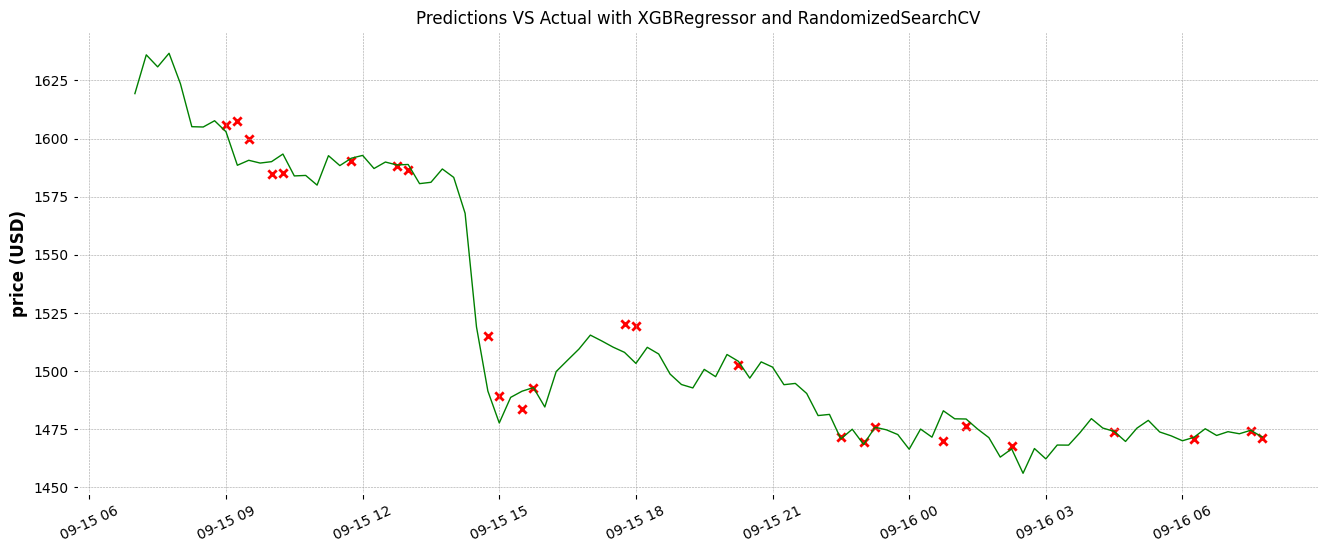

In [38]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.plot(data["close_time"], data["next_candle_close"], color="green", label="values sum", lw=1)
ax.scatter(test_df["close_time"], pipeline.predict(test_df), color="red", label="values mean", marker="x")
ax.set_title("Predictions VS Actual with XGBRegressor and RandomizedSearchCV")
ax.set_ylabel("price (USD)")
plt.xticks(rotation=25)
plt.show();

In [34]:
params = {
    "model__max_depth": [1, 10],
    "model__learning_rate": [0.0001, 0.5],
    "model__colsample_bylevel": [0.3, 0.9],
}

forrest = pipeline

search = GridSearchCV(forrest, params, cv=7, n_jobs=-1)
print(extract_best_model_params(search.get_params()))
search.fit(train_df, train_df["next_candle_close"].values)


pipeline = Pipeline(
    [
        (
            "ColumnTransformer",
            ColumnTransformer(
                [
                    ("cont_transformer", cont_pipeline, cont_features),
                ]
            ),
        ),
        ("model", XGBRegressor(**extract_best_model_params(search.best_estimator_.get_params()))),
    ]
)
pipeline.fit(train_df, train_df["next_candle_close"].values)

predictions = pipeline.predict(test_df)

print("MAE: ", mean_absolute_error(test_df["next_candle_close"], predictions))
print("MSE: ", mean_squared_error(test_df["next_candle_close"], predictions))

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.4, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.7, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 100, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
MAE:  5.689598828124999
MSE:  75.42075179553989


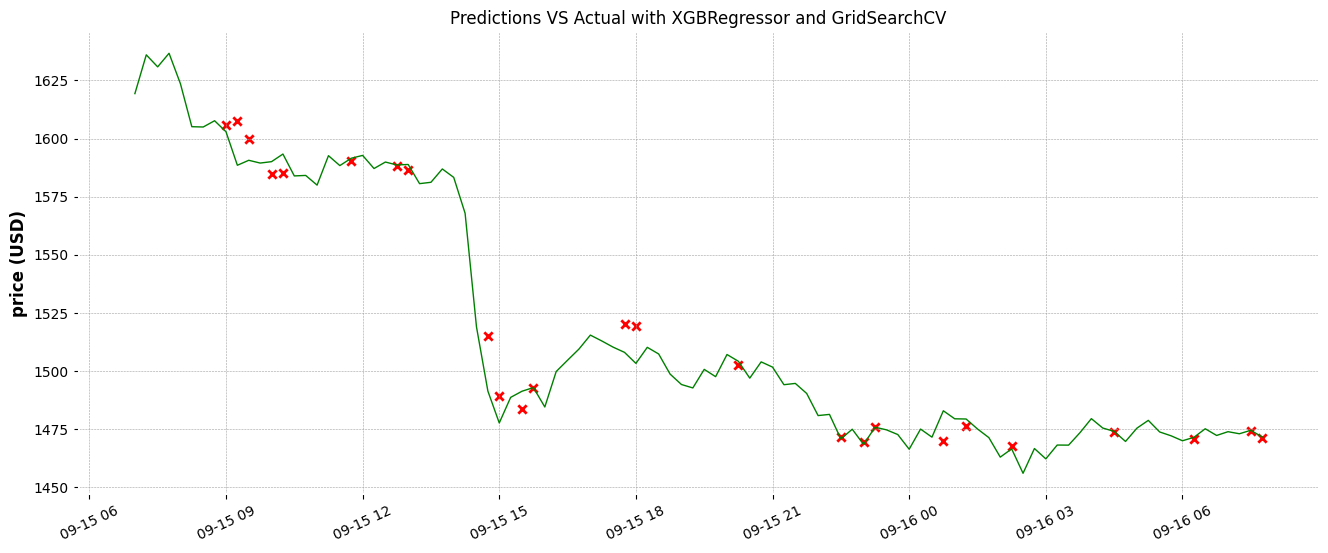

In [39]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.plot(data["close_time"], data["next_candle_close"], color="green", label="values sum", lw=1)
ax.scatter(test_df["close_time"], pipeline.predict(test_df), color="red", label="values mean", marker="x")
ax.set_title("Predictions VS Actual with XGBRegressor and GridSearchCV")
ax.set_ylabel("price (USD)")
plt.xticks(rotation=25)
plt.show();

In [36]:
cloudpickle.dump(pipeline, open("notebooks/models/model.pkl", "wb"))